In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import myst_nb

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)
        

In [ ]:
# businesses
bus = pd.read_csv('data/businesses.csv', encoding='ISO-8859-1')

def parse_dates_and_years(df, column='date'):
    dates = pd.to_datetime(df[column], format=date_format)
    years = dates.dt.year
    return df.assign(timestamp=dates, year=years)

# inspections
insp = (pd.read_csv("data/inspections.csv")
        .pipe(parse_dates_and_years))

# violations
viol = (pd.read_csv("data/violations.csv")
        .pipe(parse_dates_and_years))

(ch:wrangling_restaurants)=
# Example: Wrangling Restaurant Safety Violations

In this section, we demonstrate data wrangling techniques from this chapter on the restaurant safety dataset. The data are stored in three tables: `bus` (for businesses), `insp` (for inspections), and `viol` (for safety violations). The violations dataset contains detailed descriptions of violations found during an inspection. We would like to capture some of this information and connect it to the inspection score, which is in inspection-level dataset. 

We want to figure out: **what kinds of safety violations are associated with lower restaurant
safety scores?**

This example covers several key ideas in data wrangling related to changing structure:
+ aggregation to modify the granularity of a table
+ filtering to focus on a narrower segment of data
+ joining to bring together information across tables

Additionally, an important part of this example demonstrates how we transform text data into numeric quantities for analysis.

To get started let's peek at the first few rows of each table to remind ourselves of
what they contain.

In [ ]:
print('bus:')
display_df(bus.head(2), cols=4)

# Note that we've already parsed timestamps and years for insp and viol 
print('insp:')
display_df(insp.head(2))

print('viol:')
display_df(viol.head(2))


## Narrowing the Focus

As a first step, let's simplify the structure by reducing the data to inspections from one year. (Recall that this dataset contains four years of inspection information.)  Below we tally the number of records for each year in the inspections table.

In [49]:
pd.value_counts(insp['year'])

2016    5443
2017    5166
2015    3305
2018     308
Name: year, dtype: int64

Let's take a subset of the data, restricting our preparations to inspections that took place in 2016. Here, we'll use the pipe function once again to apply the same transformation to both the inspections and violations data frames.

In [50]:
def subset_2016(df):
    return df.query('year == 2016')

vio2016 = viol.pipe(subset_2016)
ins2016 = insp.pipe(subset_2016)

In [52]:
ins2016

,business_id,score,date,type,timestamp,year
0,19,94,20160513,routine,2016-05-13,2016
3,24,98,20161005,routine,2016-10-05,2016
4,24,96,20160311,routine,2016-03-11,2016
...,...,...,...,...,...,...
13820,90096,91,20161229,routine,2016-12-29,2016
13850,90268,100,20161229,routine,2016-12-29,2016
13852,90269,100,20161229,routine,2016-12-29,2016


Recall that `timestamp` contains the parsed timestamps. From the previous section on granularity, we also found that `business_id` and `timestamp` together uniquely identify the inspections (with a couple of exceptions).

By looking at the first few rows of `ins2016`, we can see that restaurants can receive multiple inspections in a year---business \#24 had two inspections in 2016, one in March and another in October. 

In [54]:
vio2016.head(6)

,business_id,date,description,timestamp,year
2,19,20160513,Unapproved or unmaintained equipment or utensi...,2016-05-13,2016
3,19,20160513,Unclean or degraded floors walls or ceilings ...,2016-05-13,2016
4,19,20160513,Food safety certificate or food handler card n...,2016-05-13,2016
...,...,...,...,...,...
38147,89900,20161206,No hot water or running water [ date violatio...,2016-12-06,2016
38220,90096,20161229,No plan review or Building Permit [ date viol...,2016-12-29,2016
38221,90096,20161229,Unclean or unsanitary food contact surfaces [...,2016-12-29,2016


Notice that the first few records in the `vio2016` dataframe are all for the same restaurant.

## Aggregating Violations 

Do restaurants with more violations have lower safety scores? To check this, we can count the number of violations in an inspections. To find this count, we can group this table by `business_id` and `timestamp`, then find the size of each group. Essentially, this grouping changes the granularity of violations to an inspection level.

In [56]:
num_vios = (vio2016
            .groupby(['business_id', 'timestamp'])
            .size()
            .reset_index()
            .rename(columns={0: 'num_vio'}));
num_vios

,business_id,timestamp,num_vio
0,19,2016-05-13,3
1,24,2016-03-11,2
2,24,2016-10-05,1
...,...,...,...
4803,89790,2016-11-29,1
4804,89900,2016-12-06,1
4805,90096,2016-12-29,2


Now we want to merge num_vios with `ins2016`. What kind of merge do we want to
perform? We want a *left join* of `ins2016` with `num_vios` because there could
be inspections that do not have any violations.

In [83]:
def left_join_vios(ins):
    return ins.merge(num_vios, on=['business_id', 'timestamp'], how='left')

ins_and_num_vios = ins2016.pipe(left_join_vios)
ins_and_num_vios

,business_id,score,date,type,timestamp,year,num_vio
0,19,94,20160513,routine,2016-05-13,2016,3.0
1,24,98,20161005,routine,2016-10-05,2016,1.0
2,24,96,20160311,routine,2016-03-11,2016,2.0
...,...,...,...,...,...,...,...
5440,90096,91,20161229,routine,2016-12-29,2016,2.0
5441,90268,100,20161229,routine,2016-12-29,2016,NaN
5442,90269,100,20161229,routine,2016-12-29,2016,NaN


When there are no violations for an inspection, the feature `num_vio` will have
a missing value (`NaN`). We can check how many values are missing:

In [84]:
ins_and_num_vios['num_vio'].isnull().sum()

833

So, about 15% of restaurant inspections in 2016 found no safety violations. 

We'd expect that if a restaurant received a perfect safety score of 100, the restaurant had no violations. So, we can correct these missing values by setting them to 0. This is an example of deductive imputation, since we're using domain knowledge to fill in missing values.

In [85]:
def zero_vios_for_perfect_scores(df):
    df = df.copy()
    df.loc[df['score'] == 100, 'num_vio'] = 0
    return df

ins_and_num_vios = (ins2016.pipe(left_join_vios)
                    .pipe(zero_vios_for_perfect_scores))
ins_and_num_vios

,business_id,score,date,type,timestamp,year,num_vio
0,19,94,20160513,routine,2016-05-13,2016,3.0
1,24,98,20161005,routine,2016-10-05,2016,1.0
2,24,96,20160311,routine,2016-03-11,2016,2.0
...,...,...,...,...,...,...,...
5440,90096,91,20161229,routine,2016-12-29,2016,2.0
5441,90268,100,20161229,routine,2016-12-29,2016,0.0
5442,90269,100,20161229,routine,2016-12-29,2016,0.0


Now, there are only 65 missing violation counts:

In [86]:
ins_and_num_vios['num_vio'].isnull().sum()

65

We have corrected a large number of missing values. With further investigation,
we find that some of the businesses have inspection dates in `ins2016` that
differ from the dates in `vio2016` by one or two days. We could change the
dates in `vio2016` if we wanted to fix additional missing data. We leave this
as an exercise for the reader. 

Now, let's examine the relationship between the number of violations and the
inspection score.

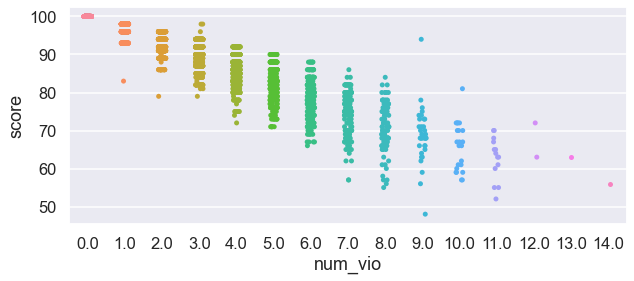

In [87]:
plt.figure(figsize=(10, 4))
sns.stripplot(x="num_vio", y="score", data=ins_and_num_vios);

As we might expect there is a negative relationship between the inspection score and the number of violations found during the inspection. We can also see
variability in score. Restaurants with four violations, have a spread in scores, and the variability in scores grows with the number of violations. It appears that some
violations are more serious than others and have a greater impact on the score.

## Extracting Information from Violation Descriptions

How can we use the information in the description of the violation to capture
the kind of violation that has occurred? We saw earlier that the feature description in the violations data frame has a lot of text, including information in square brackets about when the violation was corrected. We can tally the descriptions and examine the most common
violations.

In [71]:
display_df(vio2016['description'].value_counts().head(20), rows=20)

Unclean or degraded floors walls or ceilings                                 161
Unapproved or unmaintained equipment or utensils                              99
Moderate risk food holding temperature                                        95
Inadequate and inaccessible handwashing facilities                            93
Inadequately cleaned or sanitized food contact surfaces                       92
Improper food storage                                                         81
Wiping cloths not clean or properly stored or inadequate sanitizer            71
Food safety certificate or food handler card not available                    64
Moderate risk vermin infestation                                              58
Foods not protected from contamination                                        56
Unclean nonfood contact surfaces                                              54
Inadequate food safety knowledge or lack of certified food safety manager     52
Permit license or inspection

These descriptions are long and wordy. Reading through them, we see that some are related to the cleanliness of facilities, others are related to the food storage, and still others pertain to the cleanliness of the staff.

Since there are many types of violations, we'd like to group violations together into larger categories. One way to do this is to create a simple boolean flag depending on what the violation text contains. For example, we can create a feature called `is_high_risk`, that contains `True` if if a description contains the term "high risk".

We'll create eight new features for different categories of violations. Don't
worry about the particular details of the code for now---this code uses
regular expressions, covered in the later {ref}`ch:text` chapter. The important
idea is that this code creates features containing `True` or `False` based on
whether the violation description contains specific words.

In [76]:
def make_vio_categories(vio):
    def has(term):
        return vio['description'].str.contains(term)

    vio = vio.copy()
    vio['is_high_risk'] = has(r"high risk")
    vio['is_clean'] = has(r"clean|sanit")
    vio['is_food_surface'] = (has(r"surface") & has(r"\Wfood"))
    vio['is_vermin'] = has(r"vermin")
    vio['is_storage'] = has(r"thaw|cool|therm|storage")
    vio['is_display_permit'] = has(r"certificate|permit")
    vio['is_non_food_surface'] = has(r"wall|ceiling|floor|surface")
    vio['is_human'] = has(r"hand|glove|hair|nail")
    return vio

In [88]:
# The violations with the new categories
vio2016 = (viol.pipe(subset_2016)
           .pipe(make_vio_categories))
vio2016.head(2)

,business_id,date,description,timestamp,...,is_storage,is_display_permit,is_non_food_surface,is_human
2,19,20160513,Unapproved or unmaintained equipment or utensi...,2016-05-13,...,False,False,False,False
3,19,20160513,Unclean or degraded floors walls or ceilings ...,2016-05-13,...,False,False,True,False


Now that we have these new features in `vio2016`, we again want to merge this
information with the inspection information. We roll up the violations again to
the restaurant/date level and track whether any of the values in the group is
`True`.

In [81]:
feature_names = [
    'is_high_risk', 'is_clean', 'is_food_surface', 'is_vermin', 'is_storage',
    'is_display_permit', 'is_non_food_surface', 'is_human'
]

features = (vio2016
            .groupby(['business_id', 'timestamp'])
            [feature_names]
            .max())
features.head(2)

,,is_high_risk,is_clean,is_food_surface,is_vermin,is_storage,is_display_permit,is_non_food_surface,is_human
business_id,timestamp,,,,,,,,
19,2016-05-13,False,True,False,False,False,True,True,True
24,2016-03-11,False,True,False,False,False,False,True,False


We'll once again use a left join to merge these new features into the
inspection-level data frame, `ins2016`. And, for the special case of a score of
100, we set all of the new features to `False`.

In [91]:
def left_join_features(ins):
    return ins.merge(features, on=['business_id', 'timestamp'], how='left')

def zero_features_for_perfect_scores(ins):
    ins = ins.copy()
    ins.loc[ins['score'] == 100, feature_names] = False
    return ins

In [92]:
ins_and_vios = (ins2016.pipe(left_join_features)
                .pipe(zero_features_for_perfect_scores))
ins_and_vios

,business_id,score,date,type,...,is_storage,is_display_permit,is_non_food_surface,is_human
0,19,94,20160513,routine,...,False,True,True,True
1,24,98,20161005,routine,...,False,False,True,False
2,24,96,20160311,routine,...,False,False,True,False
...,...,...,...,...,...,...,...,...,...
5440,90096,91,20161229,routine,...,False,False,True,False
5441,90268,100,20161229,routine,...,False,False,False,False
5442,90269,100,20161229,routine,...,False,False,False,False


To see how each violation category relates to the score, we can make a collection of boxplots that compares the score distributions with and without each violation. First, we'll subset the table so that we have just the scores and the violation categories.

In [94]:
ins_and_vios[['score', *feature_names]]

,score,is_high_risk,is_clean,is_food_surface,...,is_storage,is_display_permit,is_non_food_surface,is_human
0,94,False,True,False,...,False,True,True,True
1,98,False,True,False,...,False,False,True,False
2,96,False,True,False,...,False,False,True,False
...,...,...,...,...,...,...,...,...,...
5440,91,False,True,True,...,False,False,True,False
5441,100,False,False,False,...,False,False,False,False
5442,100,False,False,False,...,False,False,False,False


Our plotting library expects long-form data, so we first use `.melt()` to
transform this table from wide-form to long-form:

In [96]:
features_long = pd.melt(ins_and_vios[['score', *feature_names]],
                        id_vars='score',
                        var_name='category',
                        value_name='violated')
features_long

,score,category,violated
0,94,is_high_risk,False
1,98,is_high_risk,False
2,96,is_high_risk,False
...,...,...,...
43541,91,is_human,False
43542,100,is_human,False
43543,100,is_human,False


Now, we make our plot:

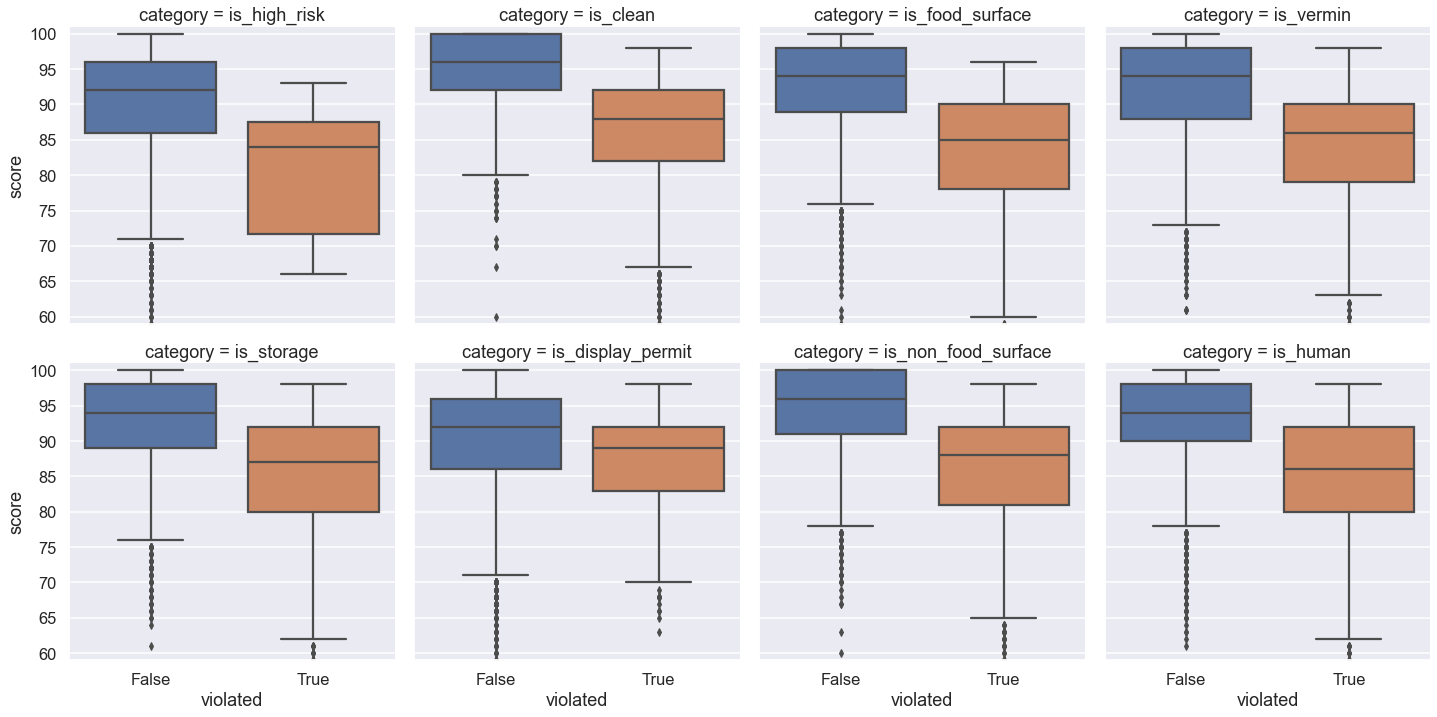

In [106]:
g = sns.catplot(data=features_long, x='violated', y='score',
                col='category', col_wrap=4, kind='box');
g.set(ylim=(59, 101));

What do we observe? Restaurants that have no cleanliness-related violations
have the highest scores. Having a display permit violation isn't much of a
detractor. And, high risk violations lower the distribution of scores more than any
other violation. These observations are just the beginning of a possible
analysis into understanding what a score means.

## Takeaways

We used several techniques from this chapter to wrangle the restaurant safety data. First, we reshaped the data to subset rows corresponding to a year's worth of data and to aggregate violation information to inspection-level granularity. We used quality checks, looked for missing values, and filled them in using deductive imputation. We also showed one way that text can be used in a data analysis by extracting features from the violation descriptions. Finally, we modified the dataframe's structure to make it easier to produce the final plots for this analysis.